In [1]:
import glob
from osmread import parse_file, Way,Node,Relation
import shapely.geometry as shpgeo
import shapely.ops as shpop
import overpy
from shapely.ops import linemerge
import time
import geopandas as gp

In [2]:
api = overpy.Overpass()
shpgeo.Polygon.centroid

In [9]:

def node2pt(node):
    return shpgeo.Point(node.lon,node.lat)
def lonlat_in_way(way):
    coors = []
    for node in way.nodes:
        coors.append((node.lon, node.lat))
    return coors
def is_closed_way(way):
    return way.nodes[0] == way.nodes[-1]

def get_relation(relation,need_api=True):
    while True:
        try:
            if need_api:
                relation = api.query("""
                relation(%s);
                (._;>;);
                out;
                """ % relation.id).relations[0]
            break
        except Exception as e:
            print e
            time.sleep(10)
    return relation

def way2line(way,need_api=True):
    while True:
        try:
            if need_api:
                way = api.query("""
                way(%s);
                (._;>;);
                out;
                """% way.id).ways[0]
            break
        except Exception as e:
            print e
            time.sleep(10)
    coors = lonlat_in_way(way)
    return shpgeo.LineString(coors)

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    from math import radians, cos, sin, asin, sqrt
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = km *1000
    return m
       
def handle_poly(name_pattern,poly):
    ext_coords = poly.exterior.coords
    centr = poly.centroid
    radius = get_max_dis_from_center_to_ext(centr, ext_coords)
    center_str = '%.6f,%.6f' %(centr.coords[0][0], centr.coords[0][1])
    return '%s\t%s\t%s\t%s\n' %(name_pattern, center_str, radius, list(poly.exterior.coords))
    

In [13]:
def remove_equal_shpobj(objs):
    import rtree
    size = len(objs)
    equal_pair = []
    keep = []
    exclude_idx = set()

    tree_idx = rtree.index.Index()
    objs_bounds = [o.bounds for o in objs]
    for i in xrange(size):
        try:
            tree_idx.insert(i, objs_bounds[i])
        except Exception as e:
            print i, objs_bounds[i], objs[i]
            raise e

    for i in xrange(size):
        if i in exclude_idx:
            continue
        keep.append(i)
        js = tree_idx.intersection(objs[i].bounds)
        for j in js:
            if i!=j and objs[i].equals(objs[j]):
                equal_pair.append((i,int(j)))
                exclude_idx.add(j)

    return keep, equal_pair
def remove_equal_shpobj(objs):
    import rtree
    size = len(objs)
    equal_pair = []
    keep = []
    exclude_idx = set()

    tree_idx = rtree.index.Index()
    objs_bounds = [o.bounds for o in objs]
    for i in xrange(size):
        try:
            tree_idx.insert(i, objs_bounds[i])
        except Exception as e:
            print i, objs_bounds[i], objs[i]
            raise e

    for i in xrange(size):
        if i in exclude_idx:
            continue
        keep.append(i)
        js = tree_idx.intersection(objs[i].bounds)
        for j in js:
            if i!=j and objs[i].equals(objs[j]):
                equal_pair.append((i,int(j)))
                exclude_idx.add(j)

    return keep, equal_pair
def rltn2dictShp(relation, sub_rltn=False):
    nodes, ways, sub_nodes, sub_ways = [], [], [], []
    for m in relation.members:
        obj = m.resolve()
        if isinstance(obj, overpy.Node):
            nodes.append(obj)
        elif isinstance(obj, overpy.Way):
            ways.append(obj)
        elif isinstance(obj, overpy.Relation):
            r_nodes, r_ways = rltn2dictShp(osm_container, obj, True)
            sub_nodes.extend(r_nodes)
            sub_ways.extend(r_ways)
    if sub_rltn:
        return nodes, ways
    nodes.extend([node for node in sub_nodes])
    ways.extend([way for way in sub_ways])

    points = [node2pt(node) for node in nodes]
    keep_pts_idx, _ = remove_equal_shpobj(points)
    points = [p for cnt, p in enumerate(points) if cnt in keep_pts_idx]

    lines = [way2line(way,False) for way in ways]
    keep_lines_idx, _ = remove_equal_shpobj(lines)
    lines = [l for cnt, l in enumerate(lines) if cnt in keep_lines_idx]

    dict_shp= { 'LineString': [], 'Polygon': []}
    if lines:
        merged = linemerge(lines)
        if merged.type == 'LineString':
            merged = [merged]
        else:
            merged = list(merged)
        for ln in merged:
            if ln.is_ring:
                dict_shp['Polygon'].append(shpgeo.Polygon(ln))
            else:
                dict_shp['LineString'].append(ln)
    return dict_shp
def merge_within_by_list_shp(list_shp):
    import geopandas as gp
    import pandas as pd
    from other_utils import find_tree
    gpdf = gp.GeoDataFrame(list_shp,columns=['geometry'])
    sjoin = gp.tools.sjoin(gpdf,gpdf,op='within')
    messy_tree_df = pd.DataFrame(zip(sjoin.index.values, sjoin.index_right.values), columns=['node','parent'])
    clean_tree_df = find_tree(messy_tree_df)
    top_level_shp_idx = clean_tree_df[clean_tree_df.parent==-1].node.values
    return gpdf[gpdf.index.isin(top_level_shp_idx)].values

def rltn2mergedListShp( relation):
    shpcltn = rltn2dictShp(relation)
    list_shp = []
    for l in shpcltn.values():
        list_shp += l
    merge_list_shp = merge_within_by_list_shp(list_shp)
    return merge_list_shp


def rltn2mergedFlattenListShp(relation):
    merge_list_shp = rltn2mergedListShp(relation)
    flat_shpcltn = []
    for shpobjs in merge_list_shp:
        flat_shpcltn.extend(shpobjs)
    return flat_shpcltn

def rltn2convexhull(relation):
    return shpgeo.MultiPolygon(rltn2mergedFlattenListShp(relation)).convex_hull

In [14]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../utils'))


In [18]:

def get_max_dis_from_center_to_ext(centr,ext_coords):
    lon1, lat1 = centr
    return max([haversine(lon1,lat1, lon2,lat2) for lon2, lat2 in ext_coords])

def get_cntr_radius(poly):
    cntr = poly.centroid.coords[0]
    ext_coords = poly.exterior.coords
    radius = get_max_dis_from_center_to_ext(cntr, ext_coords)
    return cntr, radius, ext_coords

def osm2polys(osm_data):
    if isinstance(osm_data, Way):
        ln = way2line(osm_data)
        poly = shpgeo.Polygon(ln)
        return [poly]
    if isinstance(osm_data, Relation):
        r = get_relation(osm_data)
        return rltn2mergedFlattenListShp(r)

def osms2flattenPolys(data_file_dir, geojson_file):
    place_polys = []
    for i, file_path in enumerate(glob.glob(data_file_dir+'/*')):
#         if i<=40:
#             continue
#         if i >41:
#             break
        _, place = file_path.split('\\')
        place = place[:-4].replace(' ','_')
        osm_data = parse_file(file_path)
        osm_data = list(osm_data)
        assert len(osm_data)==1, '{}th {}: len!=0'.format(i, file_path)
        print i, place, len(list(osm_data))
        osm_data = osm_data[0]
        polys = osm2polys(osm_data)
        for cnt, poly in enumerate(polys):
            cntr, radius, ext_coords = get_cntr_radius(poly)
            place_polys.append(['{}##{}'.format(place,cnt), cntr, radius+1000, poly])
        
    print len(place_polys)
    return place_polys


In [16]:

OSM_XML_DIR = u'../data/OSM_national_park@US/'
PLACE_POLYS_NP = '../data/place_polys_np.geojson'
PLACE_POLYS_NP_BFR5 = '../data/place_polys_np_5m.geojson'
PLACE_POLYS_NP_BFR10 = '../data/place_polys_np_10m.geojson'
PLACE_POLYS_NP_BFR50 = '../data/place_polys_np_50m.geojson'
PLACE_POLYS_NP_BFR100 = '../data/place_polys_np_100m.geojson'

PLACE_POLYS_NP_CONVEX = '../data/place_polys_np_convex.geojson'
PLACE_POLYS_NP_CONVEX_BFR5 = '../data/place_polys_np_convex_5m.geojson'
PLACE_POLYS_NP_CONVEX_BFR10 = '../data/place_polys_np_convex_10m.geojson'
PLACE_POLYS_NP_CONVEX_BFR50 = '../data/place_polys_np_convex_50m.geojson'
PLACE_POLYS_NP_CONVEX_BFR100 = '../data/place_polys_np_convex_100m.geojson'

In [19]:
update_polys=True
if update_polys:
    place_polys = osms2flattenPolys(OSM_XML_DIR,PLACE_POLYS_NP)
    place_polys_gpdf = gp.GeoDataFrame(place_polys,columns=['place', 'cntr','radius','geometry'])
else:
    place_polys_gpdf = gp.read_file(PLACE_POLYS_NP)
place_polys_gpdf.crs = {'init': 'epsg:4326', 'no_defs': True}

0 Acadia_NP_(ACAD) 1
1 Adams_NHP 1
2 African_Burial_Ground_NM_(AFBG) 1
3 Agate_Fossil_Beds_NM 1
4 Alibates_Flint_Quarries_NM_(ALFL) 1
5 Allegheny_Portage_Railroad_NHS_(ALPO) 1
6 Andersonville_NHS_(ANDE) 1
7 Aniakchak_NM_&_PRES_(ANIA)1 1
8 Aniakchak_NM_&_PRES_(ANIA)2 1
9 Antietam_NB_(ANTI) 1
10 Appomattox_Court_House_NHP_(APCO) 1
11 Arches_NP_(ARCH) 1
12 Arkansas_Post_NMEM_(ARPO) 1
13 Arlington_House_The_R.E._Lee_MEM_(ARHO) 1
14 Assateague_Island_NS_(ASIS) 1
15 Aztec_Ruins_NM_(AZRU) 1
16 Badlands_NP_(BADL) 1
17 Bandelier_NM_(BAND) 1
18 Bent's_Old_Fort_NHS_(BEOL) 1
19 Bering_Land_Bridge_NPRES_(BELA) 1
20 Big_Bend_NP_(BIBE) 1
21 Big_Cypress_NPRES_(BICY) 1
22 Big_Hole_NB_(BIHO) 1
23 Big_South_Fork_NRRA_(BISO) 1
24 Bighorn_Canyon_NRA 1
25 Biscayne_NP 1
26 Black_Canyon_of_the_Gunnison_NP 1
27 Blue_Ridge_PKWY 1
28 Blue_Ridge_pwky 1
29 Brown_v._Board_of_Education_NHS_[larger] 1
30 Brown_v._Board_of_Education_NHS 1
31 Bryce_Canyon_NP 1
32 Buck_Island_Reef_NM 1
33 Buffalo_NR 1
34 Cabrillo_NM 1
3

In [20]:
place_polys_gpdf.cntr = place_polys_gpdf.cntr.apply(str)
with open(PLACE_POLYS_NP,'w') as f:
    f.write(place_polys_gpdf.to_json())

In [21]:
place_polys_gpdf_tw = place_polys_gpdf.copy()
place_polys_gpdf_tw['date_until'] = '2099-01-01'
place_polys_gpdf_tw[['place','date_until','radius','cntr','geometry']].to_csv('../data/place_polys_np_tw.csv')

In [22]:
def substract_overlap(subtrahend, minuend):
    subtra_place, subtra_poly = subtrahend['place##cnt'], subtrahend.geometry
    for _,m_place,m_poly in minuend[['place##cnt','geometry']].itertuples():
        if subtra_place!=m_place and subtra_poly.distance(m_poly)==0:
            subtra_poly -= m_poly
    return subtra_poly

In [23]:
# place_polys_gpdf.geometry = place_polys_gpdf.geometry.apply(lambda x:x.convex_hull)
# # place_polys_gpdf.geometry = place_polys_gpdf.apply(lambda x: substract_overlap(x, place_polys_gpdf), axis=1)
# with open(PLACE_POLYS_NP_CONVEX,'w') as f:
#     f.write(place_polys_gpdf.to_json())

In [24]:
usa_crs = {'proj': 'aea' ,'lat_1':29.5,'lat_2':45.5,'lat_0':37.5 ,'lon_0':-96 ,
           'x_0':0, 'y_0':0, 'datum':'NAD83', 'units':'m', 'no_defs':True}

In [25]:
def get_n_write_bfr_gpdf(gpdf, bfr, crs, file_path):
    gpdf_bfr = gpdf.to_crs(crs=crs)
    gpdf_bfr.geometry = gpdf_bfr.buffer(bfr)
    gpdf_bfr = gpdf_bfr.to_crs(epsg=4326)
    with open(file_path,'w')as f:
        f.write(gpdf_bfr.to_json())
    return gpdf_bfr

place_polys_gpdf_bfr5 = get_n_write_bfr_gpdf(place_polys_gpdf, 5, usa_crs,PLACE_POLYS_NP_BFR5)
place_polys_gpdf_bfr10 = get_n_write_bfr_gpdf(place_polys_gpdf, 10, usa_crs,PLACE_POLYS_NP_BFR10)    
place_polys_gpdf_bfr50 = get_n_write_bfr_gpdf(place_polys_gpdf, 50, usa_crs,PLACE_POLYS_NP_BFR50)
place_polys_gpdf_bfr100 = get_n_write_bfr_gpdf(place_polys_gpdf, 100, usa_crs,PLACE_POLYS_NP_BFR100)

In [26]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from leaflet_creation_v2 import create_map_visualization

In [27]:
# check whether there is obvious mistake of places,
# for example, use the national protrait gallery in DC for the NPG in England
html_title = 'usa np'
file_name = 'usa np'
lon, lat  = -96, 37.5
zoom = 12
init_layers = ['streets', 'stsg_layer']
map_layers = ['light','streets']
binding_data=[['stsg','street segment']]
place_polys_gpdf_vis = place_polys_gpdf_bfr100.copy()
place_polys_gpdf_vis['color'] = '#F00'
gpdfs = [place_polys_gpdf_vis]
create_map_visualization(html_title, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

###  test us-wide projection

In [134]:
sw = (25.020411, -125.048042)
ne = (49.308516, -66.410394 )
# sw = (37.8800,-79.4900)
# ne = (39.7200,-74.9800)
 
import sys,os
sys.path.insert(0, os.path.abspath('../'))
from utils.geofunc import grid_area, haversine
import itertools
test_points = [shpgeo.Point(x[1],x[0]) for x in list(set(itertools.chain(*grid_area(sw,ne))))]
pt = test_points[0]
pt.coords[0]

(-95.729218, 42.0220845)

In [104]:
import numpy as np
import pyproj

ImportError: No module named proj

In [106]:
dist = []
for pt in test_points:
    dist.extend([haversine(pt.coords[0][0],pt.coords[0][1],x[0],x[1])for x in list(pt.buffer(10).exterior.coords)])
np_dist = np.array(dist)
np.histogram(np_dist)

(array([1318,  802,  608,  562,  498,  496,  540,  650,  628, 1752]),
 array([  851079.59824354,   877096.75189367,   903113.90554379,
          929131.05919392,   955148.21284404,   981165.36649417,
         1007182.52014429,  1033199.67379442,  1059216.82744454,
         1085233.98109467,  1111251.13474479]))

In [96]:
%matplotlib inline

[  9.82659072   9.85929876   9.8920068    9.92471484   9.95742288
   9.99013092  10.02283896  10.05554701  10.08825505  10.12096309
  10.15367113]
[ 19.60050829  19.64849291  19.69647752  19.74446214  19.79244675
  19.84043137  19.88841599  19.9364006   19.98438522  20.03236983
  20.08035445]
[ 29.36060029  29.43461804  29.50863579  29.58265354  29.65667128
  29.73068903  29.80470678  29.87872453  29.95274228  30.02676002
  30.10077777]


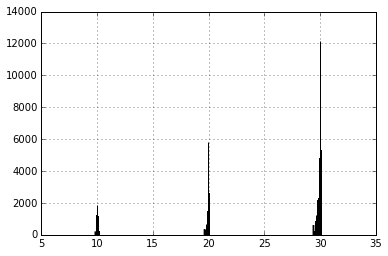

In [136]:
pts = test_points
gpdf = gp.GeoDataFrame(pts, columns=['geometry'])
gpdf.crs = {'init': 'epsg:4326', 'no_defs': True}
crss =[ 
    {'proj': 'aea' ,'lat_1':29.5,'lat_2':45.5,'lat_0':37.5 ,'lon_0':-96 ,'x_0':0, 'y_0':0, 'datum':'NAD83', 'units':'m', 'no_defs':True},
    {'proj': 'lcc' ,'lat_1':33,'lat_2':45,'lat_0':39 ,'lon_0':-96 ,'x_0':0, 'y_0':0, 'datum':'NAD83', 'units':'m', 'no_defs':True},
    {'proj': 'eqdc' ,'lat_1':33,'lat_2':45,'lat_0':39 ,'lon_0':-96 ,'x_0':0, 'y_0':0, 'datum':'NAD83', 'units':'m', 'no_defs':True}
]
for crs in crss:
    gpdf = gpdf.to_crs(crs=crs)
#     gpdf = gpdf.to_crs(epsg=3559)
    gpdf['geometry'] = gpdf.buffer(10)
    gpdf = gpdf.to_crs(epsg=4326)
    dist = []
    for pt, pt_bfr in zip(pts, gpdf.geometry.values):
#         print pt, pt_bfr.exterior.coords[0]
        dist.extend([haversine(pt.coords[0][0],pt.coords[0][1],x[0],x[1])for x in list(pt_bfr.exterior.coords)])
    np_dist = np.array(dist)
    print np.histogram(np_dist)[1]
    gp.GeoDataFrame([np_dist]).loc[0].hist()
#     break

In [ ]:
[haversine(pt.coords[0][1],pt.coords[0][0],x[1],x[0])for x in list(pt_bfr.exterior.coords)]

In [119]:

list(pt.coords)

[(-77.68599999999999, 38.616)]

In [128]:
# idx = 5

    

In [ ]:
EPSG:102003 USA_Contiguous_Albers_Equal_Area_Conic
+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs

EPSG:102004 USA_Contiguous_Lambert_Conformal_Conic
+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs

EPSG:102005 USA_Contiguous_Equidistant_Conic
+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs